## GPU Isochrones

### Load Libraries

In [1]:
import cudf
import cugraph
import cuspatial
from descartes import PolygonPatch
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from IPython.display import IFrame


ox.config(log_console=True, use_cache=True)

### Pull down Open Street Maps graph from Overpass API

In [2]:
def create_graph(loc, dist, transport_mode, loc_type='address'):
    # Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

In [3]:
%%time

# Place you are interested
place = '900 North High Street, Columbus, OH 43125'

# Transportation mode
mode = 'drive'  # options are 'walk', 'drive'

# Create network graph from place and mode
G = create_graph(place, dist=40000, transport_mode=mode, loc_type='address')

CPU times: user 3min 22s, sys: 1.78 s, total: 3min 24s
Wall time: 3min 24s


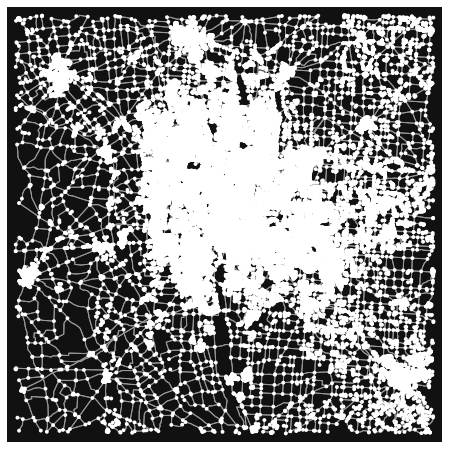

<Figure size 432x288 with 0 Axes>

CPU times: user 47 s, sys: 2.61 s, total: 49.6 s
Wall time: 44.9 s


In [4]:
%%time

fig, ax = ox.plot_graph(G, save=True);
plt.tight_layout()
#plt.savefig("graph.png")
plt.show()

In [5]:
# %%time

# graph_map = ox.plot_graph_folium(coordinates, popup_attribute='name', edge_width=2)
# # save as html file then display map as an iframe
# filepath = 'coordinates.html'
# graph_map.save(filepath)
# IFrame(filepath, width=900, height=500)

### Write graph, read graph in with cuDF and convert to cuGraph

In [6]:
%%time

# average driving speed in km/hour
travel_speed = 35
meters_per_minute = travel_speed * 1000 / 60 # km per hour to m per minute

edgelist = []
for i, j, data in G.edges(data=True):
    element = {}
    element['src'] = i
    element['dst'] = j
    element['length'] = data['length']
    element['time'] = data['length'] / meters_per_minute
    edgelist.append(element)

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 364 ms


In [7]:
%%time

edgelist_df = pd.DataFrame(edgelist)
print(edgelist_df.head())

        src        dst    length       time
0  33154031   33154064  8316.379  14.256650
1  33154064   33154066   785.422   1.346438
2  33154064  319738006   449.368   0.770345
3  33154066  319736886  2885.914   4.947281
4  33154078  319743510  5666.578   9.714134
CPU times: user 378 ms, sys: 56 µs, total: 378 ms
Wall time: 376 ms


In [8]:
%%time

gdf = cudf.DataFrame(edgelist_df)
print(gdf.head())

        src        dst    length       time
0  33154031   33154064  8316.379  14.256650
1  33154064   33154066   785.422   1.346438
2  33154064  319738006   449.368   0.770345
3  33154066  319736886  2885.914   4.947281
4  33154078  319743510  5666.578   9.714134
CPU times: user 1.27 s, sys: 520 ms, total: 1.79 s
Wall time: 1.84 s


In [9]:
%%time

# create a Graph using the source (src) and destination (dst) vertex pairs from the Dataframe 
G_gpu = cugraph.Graph()
G_gpu.from_cudf_edgelist(gdf, source='src', destination='dst', edge_attr='time')

CPU times: user 23.6 ms, sys: 12 ms, total: 35.6 ms
Wall time: 36.4 ms


## Create Isochrones from Network Graphs

In [10]:
%%time

# Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)

CPU times: user 3.1 s, sys: 15.8 ms, total: 3.12 s
Wall time: 3.11 s


In [11]:
print(type(gdf_nodes))
print(gdf_nodes)

<class 'geopandas.geodataframe.GeoDataFrame'>
                    y          x  street_count  ref            highway  \
osmid                                                                    
33154031    39.665993 -82.566110             3  NaN                NaN   
33154064    39.684365 -82.656490             3  153  motorway_junction   
33154066    39.690382 -82.661296             3  NaN                NaN   
33154078    39.721365 -82.676188             3  NaN                NaN   
33154172    39.858459 -82.828306             3  NaN                NaN   
...               ...        ...           ...  ...                ...   
8654275477  40.198762 -83.024709             1  NaN                NaN   
8654299912  40.160488 -83.160751             3  NaN                NaN   
8654407374  40.072367 -83.150045             3  NaN                NaN   
8654407382  40.072147 -83.150007             3  NaN                NaN   
8674036547  40.099639 -83.107709             3  NaN               

In [12]:
%%time

gdf_nodes_gdf = cudf.DataFrame(gdf_nodes.reset_index()[['y', 'x', 'osmid']])

CPU times: user 17.3 ms, sys: 4.04 ms, total: 21.4 ms
Wall time: 19.8 ms


In [13]:
print(gdf_nodes_gdf)

               y          x       osmid
0      39.665993 -82.566110    33154031
1      39.684365 -82.656490    33154064
2      39.690382 -82.661296    33154066
3      39.721365 -82.676188    33154078
4      39.858459 -82.828306    33154172
...          ...        ...         ...
63079  40.198762 -83.024709  8654275477
63080  40.160488 -83.160751  8654299912
63081  40.072367 -83.150045  8654407374
63082  40.072147 -83.150007  8654407382
63083  40.099639 -83.107709  8674036547

[63084 rows x 3 columns]


In [14]:
def get_nearest_node(gdf, point):
    gdf_nodes_gdf['point_y'] = point[0]
    gdf_nodes_gdf['point_x'] = point[1]
    gdf_nodes_gdf['distance'] = cuspatial.haversine_distance(gdf_nodes_gdf['y'], gdf_nodes_gdf['x'], 
                                                             gdf_nodes_gdf['point_y'], gdf_nodes_gdf['point_x'])
    mask = gdf_nodes_gdf['distance'] == gdf_nodes_gdf['distance'].min()
    nearest_node = gdf_nodes_gdf[mask].to_pandas()['osmid'].values[0]
    gdf_nodes_gdf.drop(['point_y', 'point_x', 'distance'], axis=1)
    return nearest_node

In [15]:
%%time

# Specify where you want to start and get nearest nodes.
point_of_interest = ox.get_nearest_node(G, point=(39.98042534774855, -82.9957527350642))
print(point_of_interest)

1848537260
CPU times: user 105 ms, sys: 34 µs, total: 105 ms
Wall time: 103 ms


In [16]:
%%time

# Specify where you want to start and get nearest nodes. (GPU accelerated)
point_of_interest = get_nearest_node(gdf_nodes_gdf, point=(39.98042534774855, -82.9957527350642))
print(point_of_interest)

230271954
CPU times: user 387 ms, sys: 11.9 ms, total: 399 ms
Wall time: 397 ms


In [17]:
gdf_nodes_gdf.head()

,y,x,osmid,point_y,point_x,distance
0,39.665993,-82.566110,33154031,39.980425,-82.995753,47.975509
1,39.684365,-82.656490,33154064,39.980425,-82.995753,37.947543
2,39.690382,-82.661296,33154066,39.980425,-82.995753,37.407038
3,39.721365,-82.676188,33154078,39.980425,-82.995753,35.715021
4,39.858459,-82.828306,33154172,39.980425,-82.995753,18.694303


In [18]:
%%time

shortest_paths = cugraph.traversal.sssp(G_gpu, point_of_interest)
shortest_paths = shortest_paths.drop('predecessor', axis=1)
shortest_paths.columns = ['time', 'osmid']
print(shortest_paths)

            time      osmid
0      32.681724  229955047
1      19.054863  229955069
2      19.998381  229955100
3      30.906309  229955123
4      31.077612  229955129
...          ...        ...
63079  12.773235  229858427
63080  35.372854  229858492
63081  38.004435  229858657
63082  38.458402  229858675
63083  28.897641  229858808

[63084 rows x 2 columns]
CPU times: user 194 ms, sys: 3.92 ms, total: 198 ms
Wall time: 196 ms


In [19]:
print(shortest_paths.dtypes)

time     float64
osmid      int64
dtype: object


In [20]:
%%time

results = cudf.merge(shortest_paths, gdf_nodes_gdf[['osmid', 'y', 'x']], on='osmid', how='inner')
# shortest_paths.merge(gdf_nodes_gdf[['osmid', 'y', 'x']], on='osmid', how='inner')
print(results.head())

        time      osmid          y          x
0  25.942675  230087270  39.858384 -82.975785
1  28.043199  230087278  39.910745 -82.861022
2  31.589114  230087508  40.060184 -83.125308
3  32.890658  230088142  40.132851 -82.972735
4  34.286374  230088171  40.025401 -82.805542
CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 10.2 ms


In [21]:
%%time

# Trip time in Mintues
trip_times = [5, 10, 15, 30, 60]

for trip_time in trip_times:
    results['within_' + str(trip_time)] = 1.0 * (results['time'] < trip_time)
print(results.head())

        time      osmid          y          x  within_5  within_10  within_15  \
0  25.942675  230087270  39.858384 -82.975785         0          0          0   
1  28.043199  230087278  39.910745 -82.861022         0          0          0   
2  31.589114  230087508  40.060184 -83.125308         0          0          0   
3  32.890658  230088142  40.132851 -82.972735         0          0          0   
4  34.286374  230088171  40.025401 -82.805542         0          0          0   

   within_30  within_60  
0          1          1  
1          1          1  
2          0          1  
3          0          1  
4          0          1  
CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 17.8 ms


In [22]:
%%time

# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    mask = results['within_' + str(trip_time)] == 1
    subset = results[mask].to_pandas()
    node_points = [Point((row['x'], row['y'])) for _, row in subset.iterrows()]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # TODO use cuspatial
    isochrone_polys.append(bounding_poly)

CPU times: user 14.3 s, sys: 11.8 ms, total: 14.3 s
Wall time: 14.3 s


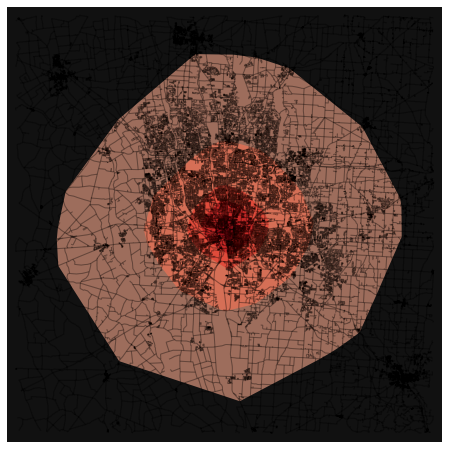

CPU times: user 43.3 s, sys: 192 ms, total: 43.5 s
Wall time: 43.3 s


In [23]:
%%time

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, figsize=(8, 8), show=False, close=False, save=True, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()